## Multiunit recordings from several cortical areas

We will collect neurons from several cortical areas to perform population *dynamical* and *attractor* analysis, and get the *functional connectivity*.     
This will address three relevant points:
- Does the dynamic analysis hold at **higher temporal resolution**?
    - How do events statistics (duration and size) compare to 2-photon?
- Are population events only a **side-effect of behavior** (locomotion, whisker pad, pupil)?
    - Do behavioral components explain pattern reproducibility?
- Do **all areas of cortex** show attractor dynamics?
    - How do pattern trajectories compare to MICrONS?

To do all this, we analyse the [data](https://janelia.figshare.com/articles/dataset/Eight-probe_Neuropixels_recordings_during_spontaneous_behaviors/7739750/4) by [Stringer et al. 2019](science.org/doi/10.1126/science.aav7893).   
Eight-probe Neuropixels recordings in three mice during spontaneous activity.   

This notebook calls `dynamical_analysis.ipynb` and `attractor_analysis.ipynb`.

In [1]:
from platform import python_version
print(python_version())

from builtins import exec
exec(open("./imports_functions.py").read())

%matplotlib inline

3.10.4


**WARNING**: the next cell takes time to download and unzip the neuropixel data.

In [2]:
if not os.path.exists("stringer/7739750.zip"):
    print("Downloading neuropixel data ...")
    if not os.path.exists("stringer"):
        os.makedirs("stringer")
    resp = wget.download("https://janelia.figshare.com/ndownloader/articles/7739750/versions/4", "stringer/7739750.zip")
    print("... Done: "+resp)

if not os.path.exists("stringer/7739750"):
    # unzip downloaded folder
    if os.path.exists("stringer/7739750.zip"):
        print("... unzipping")
        shutil.unpack_archive("stringer/7739750.zip", "stringer/7739750")
        shutil.unpack_archive("stringer/7739750/spks.zip", "stringer/7739750/spks")
        shutil.unpack_archive("stringer/7739750/faces.zip", "stringer/7739750/faces")
    print("Done.")
else:
    print("All data available.")

All data available.


### Data preprocessing

This analysis is based on the file `ephysLoad.m`.

Each "spks" is a structure of length 8, where each entry is a different probe (these probes were recorded simultaneously). It contains the spike times (in seconds, e.g. 4048.44929626 sec (?kHz sampling)), the cluster identity of each spike (its cell), and the height of each cluster on the probe.

The location of each site on the probe in microns in the Allen CCF framework is given in "ccfCoords". The brain area for each site is in "borders" as a function of the height of the site. 

We need the spikes from each area and probe to be separate lists. So, we build a dictionary to hold them, and save it locally as `area_spiketrains.npy`.

In [3]:
if os.path.exists("stringer/7739750/area_spiketrains.npy"):
    area_spiketrains = np.load("stringer/7739750/area_spiketrains.npy", allow_pickle=True).item()
    print("... loaded populations")
else:
    print("... collecting populations")
    
    probeLoc = sio.loadmat('stringer/7739750/probeLocations.mat')
    probeBorders = sio.loadmat('stringer/7739750/probeBorders.mat', squeeze_me=True)

    mouse_names = ['Krebs','Waksman','Robbins']
    cortical_areas = ['FrCtx','FrMoCtx','SomMoCtx','SSCtx','V1','V2','RSP']

    # first count the cells you want to take with this structure
    # then think on how you want to store the spikes... compatible with the dynamical_analysis
    area_spiketrains = {
        'Krebs' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]},
        'Waksman' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]},
        'Robbins' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]}
    }

    for imouse in range(len(mouse_names)):
        print(mouse_names[imouse])

        spks = sio.loadmat('stringer/7739750/spks/spks%s_Feb18.mat'%mouse_names[imouse], squeeze_me=True)

        # probe k
        # k = 7
        for k in range(8):
            print("probe",k)

            # spike times (in seconds)
            st = spks['spks'][k][0]
            # clusters
            clu = spks['spks'][k][1]
            print("clusters (cells) of the spikes",len(np.unique(clu)))
            # cluster heights (in microns)
            # (see siteCoords to convert to site location)
            Wh = spks['spks'][k][2]

            # where is the probe in the brain (consolidated labels)
            # borders are in microns
            # use Wh to determine which clusters are in which brain region
            borders = probeBorders['probeBorders'][imouse]['borders'][k]
            for j in range(len(borders)):
                population = [] # one population per border, there can be several borders
                b = borders[j]
                if b[2] not in cortical_areas:
                    continue
                print('upper border %d um, lower border %d um, area %s'%(b[0],b[1],b[2]))
                wneurons = np.logical_and(Wh>=b[1], Wh<b[0])
                nn = wneurons.sum()
                print('%d neurons in %s'%(nn,b[-1]))
                # we should not include population smaller than those in MICrONS
                if nn<10:
                    print('population too small. Rejected.')
                    continue

                cortical_neurons = np.nonzero(wneurons)[0]
                for cn in cortical_neurons:
                    cn_idxs = [i for i in range(len(clu)) if clu[i]==cn]
                    # print(cn_idxs)
                    population.append( sorted(st[cn_idxs]) )
                    
                area_spiketrains[ mouse_names[imouse] ][ b[2] ].append( population )
            print()

    # save to file
    np.save("stringer/7739750/area_spiketrains.npy", area_spiketrains)


... loaded populations


The following spiketrains will be loaded.

| mouse | probe | borders (um) | area | #neurons |
|:----|:----|:----|:---|:---|
| **Krebs** | 0 | 4000, 1100 | FrMoCtx | 5 |
|           | 1 | 4000, 1800 | FrMoCtx | 73 |
|           | 2 | 4000, 2600 | V1 | 61 |
|           | 3 | 4000, 2400 | V1 | 141 |
|           | 4 | 4000, 1800 | SomMoCtx | 65 |
|           | 5 | 4000, 2100 | SomMoCtx | 26 |
|           | 6 | 4000, 2350 | V1 | 68 |
|           | 7 | 4000, 2600 | V1 | 64 |
| **Waksman** | 0 | 4000, 1700 | FrMoCtx | 446 |
|             | 0 | 1200, 0 | FrMoCtx | 201 |
|             | 1 | 4000, 2150 | FrCtx | 31 |
|             | 2 | 4000, 2700 | V1 | 155 |
|             | 3 | 4000, 2250 | RSP | 112 |
|             | 4 | 4000, 2000 | SomMoCtx | 220 |
|             | 5 | 4000, 2600 | SSCtx | 50 |
|             | 6 | 4000, 2650 | V2 | 124 |
|             | 7 | 4000, 2850 | V1 | 96 |
| **Robbins** | 0 | 4000, 3400 | FrMoCtx | 16 |
|             | 1 | 4000, 3100 | FrMoCtx | 70 |
|             | 3 | 4000, 3550 | RSP | 10 |
|             | 4 | 4000, 3500 | SomMoCtx | 10 |


In [4]:
real_frame_duration = 0.00000001 # sec (e.g. 4048.44929626 s)
# frame_duration = 0.001 # sec (e.g. 4048.449 s)
frame_duration = 0.01 # sec (e.g. 4048.45 s)
local_path = os.getcwd() + '/stringer/7739750/'

#### Note
The cell below is particularly long to execute if the dynamical and attractor analyses are used. We therefore used only the first mouse 'Krebs' to perform those analyses.     
However, functional correlations and hirarchical modularity are light enough to be performed on all mice (with a good bit of patience). By commenting the sections on 


mouse: Krebs
area:  FrMoCtx
population: 0
area:  SomMoCtx
population: 0
population: 1
area:  V1
population: 0


KeyboardInterrupt: 

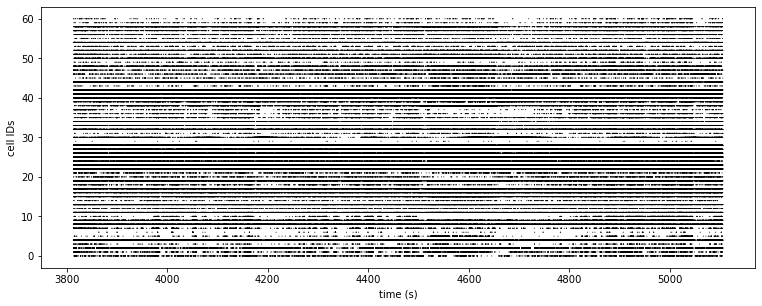

In [5]:
# start of spontaneous activity in each mouse (in seconds)
etstart = [3811, 3633, 3323]

for imouse,(mousename,areas) in enumerate(area_spiketrains.items()):
    print("\nmouse:",mousename)
    
    exp_path = local_path + '%s/'%mousename
    exp_tstart = etstart[imouse]

    # reading behavior data to make statistics about event dependence on it
    # we will use the field 'stimulus' to store the avg motSVD of the frames 
    # The behavioral file is the processed version of a mouse face movie (time x pixels x pixels). 
    faces = sio.loadmat('stringer/7739750/faces/%s_face_proc.mat'%mousename, squeeze_me=True)
    video_timestamps = faces['times'] # same temporal resolution of ephy
    motSVD = faces['motionSVD']
    exp_istart = (np.abs(video_timestamps - exp_tstart)).argmin()    
    motSVD_1c = motSVD[:,0] # only first component
    motSVD_1c[motSVD_1c < -4000] = np.mean(motSVD_1c) # corrections
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(video_timestamps[exp_istart:], motSVD_1c[exp_istart:], linewidth=0.5, color='k')
    fig.savefig(exp_path+"/motSVD_%s.png"%mousename, transparent=True, dpi=900)
    plt.close()
    fig.clear()
    fig.clf()

    for area,probe_populations in areas.items():
        if len(probe_populations)>0:
            print("area: ",area)
                        
            for ipop,spiketrains in enumerate(probe_populations): 
                print("population:",ipop)

                # rounding to ms
                spiketrains = [np.round(sp, 3) for sp in spiketrains]
                start_time = min([min(st) if len(st) else 0 for st in spiketrains])
                stop_time = max([max(st) if len(st) else 0 for st in spiketrains])
                time = np.arange(start_time,stop_time,frame_duration)

                fig = plt.figure(figsize=[12.8,4.8])
                for row,train in enumerate(spiketrains):
                    plt.scatter( train, [row]*len(train), marker='o', edgecolors='none', s=1, c='k' )
                plt.ylabel("cell IDs")
                plt.xlabel("time (s)")
                # plt.show()
                fig.savefig(exp_path+'%s_%s_rasterplot.png'%(area,ipop), transparent=False, dpi=800)
                plt.tight_layout()
                plt.close()
                
                ophys_cell_ids = list(range(len(spiketrains)))
                ophys_cell_indexes = ophys_cell_ids # here is an alias

                scan_spiketrains = spiketrains
                scan_id = '_%s_%s'%(area,ipop)
                
                # ---- start ---- comment out for all mice
                # core_reproducibility_perc = 60 # threshold for detecting cores
                # %run "dynamical_analysis.ipynb"
                
                # # Match smooth motion energy curve with the cluster it belongs to
                # # Count the number of events belonging to a pattern before and after the change.
                # ccolors,ccounts = np.unique(cluster_color_array, return_counts=True)
                # cluster_events_counts = dict(zip(ccolors,ccounts))
                # Npre_beh_cluster = {el:0. for el in np.unique(cluster_color_array)}
                # Npost_beh_cluster = {el:0. for el in np.unique(cluster_color_array)}
                # for sni in smoothed_beh_indices:
                #     snitime = exp_tstart + sni * frame_duration
                #     snitime_pre = snitime - 0.15 # s
                #     snitime_post = snitime + 0.15 # s
                #     for ievent,(event,ecolor) in enumerate(zip(events,cluster_color_array)):
                #         event_start_time = exp_tstart + event['start'] * frame_duration
                #         if snitime_pre < event_start_time and event_start_time < snitime:
                #             Npre_beh_cluster[ecolor] += 1
                #         if snitime < event_start_time and event_start_time < snitime_post:
                #             Npost_beh_cluster[ecolor] += 1
                # # detail
                # fig = plt.figure()
                # plt.scatter(range(len(Npre_beh_cluster.keys())), Npre_beh_cluster.values(), marker='<', c=list(Npre_beh_cluster.keys()), edgecolors=list(Npre_beh_cluster.keys()), s=1)
                # plt.scatter(range(len(Npost_beh_cluster.keys())), Npost_beh_cluster.values(), marker='>', c=list(Npost_beh_cluster.keys()), edgecolors='none', s=1)
                # plt.vlines(range(len(Npost_beh_cluster.keys())), Npost_beh_cluster.values(), Npre_beh_cluster.values(), colors=list(Npost_beh_cluster.keys()), linewidths=0.6)
                # plt.ylabel('occurrence')
                # plt.xlabel('Patterns')
                # fig.savefig(exp_path+"/results/Pattern_behavior_%s_%s%s.png"%(mousename,area,ipop), transparent=True, dpi=600)
                # plt.close()
                # fig.clear()
                # fig.clf()
                # # summary
                # Nsame = 0
                # Npost = 0
                # Npre = 0
                # for pre,post in zip(Npre_beh_cluster.values(),Npost_beh_cluster.values()):
                #     if pre==post: Nsame +=1
                #     if pre>post: Npre +=1
                #     if pre<post: Npost +=1
                # fig = plt.figure()
                # plt.bar([0,1,2], [Npre,Nsame,Npost], width=0.8, color='C0')
                # plt.ylabel('occurrences')
                # plt.xlabel('pattern timing relative to movement')
                # plt.xticks(range(3),['before','same','after'])
                # fig.savefig(exp_path+"/results/Pattern_behavior_summary_%s_%s%s.png"%(mousename,area,ipop), transparent=True, dpi=600)
                # plt.close()
                # fig.clear()
                # fig.clf()
                
                # # dimensional reduction, trajectories, and manifold checking
                # %run "attractor_analysis.ipynb"
                
                # ---- end ---- comment out for all mice
                
                # structural analysis
                # make binary spiketrains
                binary_spiketrains = np.zeros( (len(spiketrains),len(time)+2) )
                print(binary_spiketrains.shape)
                for row,train in enumerate(spiketrains):
                    # iterate over spiketrains assigning 1 to the binary_spiketrains at the corresponding position
                    tidxs = np.trunc(train/frame_duration).astype(int) - int(exp_tstart/frame_duration)
                    tidxs[tidxs>len(time)] = len(time) 
                    binary_spiketrains[row][tidxs] = 1
                # matrix
                print("... starting functional adjacency matrix")
                functional_adjacency_matrix = []
                for irow,bsti in enumerate(binary_spiketrains):
                    row_xcorr = []
                    for jrow,bstj in enumerate(binary_spiketrains):
                        if irow==jrow:
                            row_xcorr.append(0.0) # no self connections
                            continue
                        row_xcorr.append(crosscorrelation(bsti, bstj, maxlag=1, mode='corr')[2])
                    functional_adjacency_matrix.append(row_xcorr)
                functional_adjacency_matrix = np.array(functional_adjacency_matrix)
                print("    adjacency matrix:",functional_adjacency_matrix.shape)
                np.save(exp_path+"/results/functional_adjacency_matrix_%s%s.npy"%(area,ipop), functional_adjacency_matrix)
                # plot
                fig = plt.figure()
                plt.pcolormesh(functional_adjacency_matrix)
                cbar = plt.colorbar()
                fig.savefig(exp_path+'/results/adjacency_matrix_%s%s.png'%(area,ipop), transparent=True)
                plt.close()
                fig.clear()
                fig.clf()
                # creating graph from functional_adjacency_matrix as in Sadovsky and MacLean 2013
                functional_adjacency_matrix[ functional_adjacency_matrix <= functional_adjacency_matrix.max()*0.4 ] = 0.0
                functional_adjacency_matrix[ functional_adjacency_matrix >= functional_adjacency_matrix.max()*0.4 ] = 1.0
                dgraph = ig.Graph.Weighted_Adjacency(functional_adjacency_matrix, mode='directed')
                ig.plot(dgraph, exp_path+'/results/ring_%s%s.png'%(area,ipop), layout=dgraph.layout("circle"), edge_curved=0.2, edge_color='#000', edge_width=0.5, edge_arrow_size=0.1, vertex_size=5, vertex_color='#000', margin=50)
                degrees = np.array(dgraph.degree())
                print("... Degree distributions")
                # https://igraph.org/python/api/latest/igraph._igraph.GraphBase.html#degree
                degdist = dgraph.degree_distribution(bin_width=5)
                degree_counts = [bi[2] for bi in degdist.bins()]
                fig = plt.figure()
                plt.plot(range(len(degree_counts)), degree_counts, linewidth=3.0)
                plt.ylabel('Number of vertices')
                plt.xlabel('Degree')
                plt.xscale('log')
                plt.yscale('log')
                plt.savefig(exp_path+'/results/degree_distribution_%s%s.png'%(area,ipop), transparent=True, dpi=300)
                plt.close()
                # Clustering Coefficient of only excitatory cells
                print('... Local Clustering Coefficient')
                # undirected only
                local_clustering_coefficients = np.array(dgraph.transitivity_local_undirected(vertices=None, mode="zero"))
                # fitting
                def powerlaw(x, a, b):
                    return a * (x**-b)
                paramsfit = [2, 1.05] # 334 EM-only all proofread
                # paramsfit = [1, 0.5] # 112 Ca/EM
                pfit = powerlaw(degrees, *paramsfit)
                # Coefficient of Determination
                # In the best case, the modeled values exactly match the observed values, which results in ss_res=0 and r2=1.
                # A baseline model, which always predicts np.mean(LCC), will have r2=0.
                # Models that have worse predictions than this baseline will have a negative r2.
                # residual sum of squares
                ss_res = np.sum((local_clustering_coefficients - pfit) ** 2)
                # total sum of squares
                ss_tot = np.sum((local_clustering_coefficients - np.mean(local_clustering_coefficients)) ** 2)
                # r-squared goodeness-of-fit
                r2 = 1 - (ss_res / ss_tot)
                # covariance matrix and eigenvalues/vectors
                Cov = np.cov(degrees,local_clustering_coefficients)
                # print("    Covariance matrix degrees,local_clustering_coefficients:")
                # print(Cov)
                w, v = np.linalg.eig(Cov)
                # plot
                fig = plt.figure()
                summer = mpcm.summer
                # for deg,ccoef in zip(degrees,local_clustering_coefficients):
                #     plt.scatter( deg, ccoef, marker='o', facecolor='#AAD400', s=10, edgecolors='none', alpha=0.25) # 22um
                plt.scatter( degrees,local_clustering_coefficients, marker='o', facecolor='#111111', s=50, edgecolors='none', alpha=0.5) 
                plt.plot(degrees,pfit,c='k')
                plt.yscale('log')
                plt.xscale('log')
                # plt.xlim([10,200])
                # plt.ylim([0.01,1])
                ax = plt.gca()
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                plt.ylabel('LCC')
                plt.xlabel('degree')
                # ax.set_xticklabels([])
                # ax.set_yticklabels([])
                plt.tick_params(axis='both', bottom='on', top='on', left='off', right='off')
                plt.title("eigv: {:.2f}, {:.4f} - fit x^: {:.2f} - GoF R2={:.2f}".format(w[0], w[1], paramsfit[1], r2))
                plt.tight_layout()
                fig.savefig(exp_path+"/results/hierarchical_modularity_%s%s.svg"%(area,ipop), transparent=True, dpi=900)
                plt.close()
                fig.clf()
                
    gc.collect()
    print()
    
    # 0/0 # using only 'Krebs' mouse to save execution time.
    